In [1]:
from IPython.display import display, HTML 

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h1 style="color:red;">DI-725 : Transformers and Attention-Based Deep Networks</h1>
  <h2 style="color:red;">Final Project : Phase - 2</h2>
  <h2 style="color:red;">Ablation Study</h2>
  <br><br>
  <h4 style="color:red;">Turgay Yıldız</h4>
  <br>
  <h4 style="color:red;">Graduate School of Informatics, Middle East Technical University (METU)</h4>
</div>

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;">Fetch big_vision code and install dependencies</h3>
</div>

In [2]:
import os
import sys
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn

In [3]:
# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

In [4]:
# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

In [5]:
# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 2.2 MB/s eta 0:00:00


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Model and Pre-trained weights : </h3>
</div>

In [6]:
import os

In [7]:
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["..."]      =    '...'
os.environ["..."]      =    '...'

In [8]:
# The T4 runtime is tight on memory to finetune this model. Preallocate
# all memory ahead of time to avoid OOM'ing due to fragmentation.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [9]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import kagglehub

In [10]:
# Use these for PaliGemma 1:
LLM_VARIANT   = "gemma_2b"
MODEL_PATH    = "./paligemma-3b-pt-224.f16.npz"
KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"

In [11]:
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

Model path: /kaggle/input/paligemma/jax/paligemma-3b-pt-224/1/./paligemma-3b-pt-224.f16.npz


In [12]:
TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !wget https://storage.googleapis.com/big_vision/paligemma_tokenizer.model -O {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")


--2025-05-13 23:41:54--  https://storage.googleapis.com/big_vision/paligemma_tokenizer.model
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.207, 108.177.12.207, 173.194.210.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4264023 (4.1M) [application/octet-stream]
Saving to: ‘./paligemma_tokenizer.model’

./paligemma_tokeniz 100%[===================>]   4.07M  5.62MB/s    in 0.7s    

2025-05-13 23:41:55 (5.62 MB/s) - ‘./paligemma_tokenizer.model’ saved [4264023/4264023]

Tokenizer path: ./paligemma_tokenizer.model


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Core Library Imports : </h3>
</div>

In [13]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding


2025-05-13 23:41:59.355307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747179719.579104      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747179719.638036      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
##################################################################################################################
#                                   Set seeds for reproducibility
##################################################################################################################
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
jax_rng_key = jax.random.PRNGKey(SEED)

INFO:2025-05-13 23:42:11,571:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-13 23:42:11,584:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Reserve GPU/TPU for JAX </h3>
</div>

In [15]:
# Don't let TF use the GPU or TPUs
# Disables TensorFlow’s access to GPUs/TPUs so JAX can fully utilize them without resource contention.
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.5.2
JAX platform: gpu
JAX devices:  1


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;">Construct model and load params into RAM </h3>

 <h5 style="color:red;"> model_config: hyperparameters for both the vision encoder and text decoder.
<br>
                          Instantiate the combined Vision+LLM model.
<br>
                          Load pretrained weights into a parameter tree.
<br>
                          Build a decode function for efficient batched generation.
                          </h5>


</div>

In [16]:
MODEL_CONFIG = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})

In [17]:
model     = paligemma.Model(**MODEL_CONFIG)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

In [18]:
# Define `decode` function to sample outputs from the model.
decode_fn  =   predict_fns.get_all(model)['decode']
decode     =   functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Sharding & Casting Parameters :  </h3>

  <h5 style="color:red;">  Sharding: split tensors across devices (if you had >1 GPU).
<br>
                        maybe_cast_to_f32: keep the frozen weights in fp16 to save memory; cast the few trainable ones to fp32 so their gradients remain stable.
<br>
                        The loop unpacks the parameter tree, reshares & casts each leaf, and reassembles it.
</h5>
</div>


In [19]:
# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

In [20]:
@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Define preprocess functions to create inputs to the model :  </h3>
</div>

In [21]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]
#----------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------#
def preprocess_tokens(suffix: str | None, seqlen: int = None,  PROMPT_LEN : int = None):
    """
    Tokenize only the suffix (caption) and build masks,
    leaving room for PROMPT_LEN soft‐prompt embeddings.

    Returns:
      tokens      : np.int32 array of length seqlen (or PROMPT_LEN if no suffix)
      mask_ar     : np.int32 array, 0=full attention (for prefix), 1=causal (for suffix)
      mask_loss   : np.int32 array, 0=no loss on prefix, 1=loss on suffix
      mask_input  : np.int32 array, 1=real token, 0=padding
    """
    # 1) Tokenize suffix if given
    if suffix is not None:
        # separator token
        sep_ids = tokenizer.encode("\n", add_bos=False, add_eos=False)
        suf_ids = tokenizer.encode(suffix, add_bos=False, add_eos=True)

        tokens_suf    = sep_ids + suf_ids
        mask_ar_suf   = [1] * len(tokens_suf)
        mask_loss_suf = [1] * len(tokens_suf)
    else:
        tokens_suf    = []
        mask_ar_suf   = []
        mask_loss_suf = []

    # 2) Build the combined sequence
    #    Prefix (soft prompts) occupy positions [0..PROMPT_LEN-1], so we
    #    start our discrete IDs at index PROMPT_LEN.
    tokens     = [0] * PROMPT_LEN  + tokens_suf
    mask_ar    = [0] * PROMPT_LEN  + mask_ar_suf
    mask_loss  = [0] * PROMPT_LEN  + mask_loss_suf
    mask_input = [0] * PROMPT_LEN  + [1] * len(tokens_suf)

    # 3) Pad/truncate to seqlen if requested
    if seqlen is not None:
        length = len(tokens)
        if length < seqlen:
            pad_len = seqlen - length
            tokens     += [0] * pad_len
            mask_ar    += [0] * pad_len
            mask_loss  += [0] * pad_len
            mask_input += [0] * pad_len
        else:
            tokens     = tokens[:seqlen]
            mask_ar    = mask_ar[:seqlen]
            mask_loss  = mask_loss[:seqlen]
            mask_input = mask_input[:seqlen]

    # 4) Return as arrays
    return (
        np.array(tokens,     dtype=np.int32),
        np.array(mask_ar,    dtype=np.int32),
        np.array(mask_loss,  dtype=np.int32),
        np.array(mask_input, dtype=np.int32),
    )
#----------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------#
def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Import Data  :  </h3>
</div>

In [22]:
import tensorflow as tf
import pandas as pd

In [23]:
captions_df = pd.read_csv('/kaggle/input/rsics-dataset/captions.csv')
print(captions_df.head()) 

  source split           image  \
0   NWPU  test  NWPU_31430.jpg   
1   NWPU  test  NWPU_31431.jpg   
2   NWPU  test  NWPU_31432.jpg   
3   NWPU  test  NWPU_31433.jpg   
4   NWPU  test  NWPU_31434.jpg   

                                           caption_1  \
0   A gray plane on the runway and the lawn beside .   
1  Three small planes parked in a line on the air...   
2  A plane parked in a line on the airport with s...   
3  A small plane and a big plane parked next to b...   
4       Two planes parked next to boarding bridges .   

                                           caption_2  \
0        A grey plane is on the runway by the lawn .   
1  There are four aircraft on the open ground, Th...   
2  A white plane was parked on the instruction li...   
3  A white plane and a gray plane parked at the b...   
4  Two aircraft were parked at the departure gates .   

                                           caption_3  \
0  There is an airplane on the runway with a larg...   
1  There 

In [24]:

IMAGE_ROOT = "/kaggle/input/rsics-dataset/resized" 
BATCH_SIZE = 8 
IMG_SIZE   = (224, 224) 

In [25]:
print("All split labels:", captions_df['split'].unique())
print("Counts:\n", captions_df['split'].value_counts())

All split labels: ['test' 'val' 'train']
Counts:
 split
train    35614
test      4454
val       4453
Name: count, dtype: int64


In [26]:
# 4. Filter into splits
splits = {}
for split_name in ['train', 'val', 'test']:
    splits[split_name] = captions_df[captions_df['split'] == split_name]

In [27]:
# 5. Convert each split-DataFrame into (paths, captions)
def df_to_paths_and_captions(split_df):
    # Full paths
    paths = split_df['image'].apply(lambda fn: os.path.join(IMAGE_ROOT, fn)).tolist()
    # List-of-captions per example
    captions_cols = [f'caption_{i}' for i in range(1,6)]
    captions = split_df[captions_cols].values.tolist()
    return paths, captions

In [28]:
train_paths, train_caps = df_to_paths_and_captions(splits['train'][:1000])
val_paths,   val_caps   = df_to_paths_and_captions(splits['val'][:100])
test_paths,  test_caps  = df_to_paths_and_captions(splits['test'])

In [29]:
# 6. Preprocessing fn: load image + return captions list
def _load_and_preprocess(path, captions):
    # Read & decode
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    # Resize & normalize
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, captions

# 7. Build the tf.data pipeline
def make_dataset(paths, captions, shuffle=False):
    # turn your Python list-of-strings into a tf.string tensor
    paths_ds = tf.data.Dataset.from_tensor_slices(tf.constant(paths, dtype=tf.string))
    # turn your list-of-lists-of-strings into a [5] tf.string tensor
    caps_ds  = tf.data.Dataset.from_tensor_slices(tf.constant(captions, dtype=tf.string))

    ds = tf.data.Dataset.zip((paths_ds, caps_ds))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ( ds
           .map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE)
         )
    return ds

In [30]:
train_ds = make_dataset(train_paths, train_caps, shuffle=True)
val_ds   = make_dataset(val_paths,   val_caps,   shuffle=True)
test_ds  = make_dataset(test_paths,  test_caps,  shuffle=False)

In [31]:
def train_data_iterator(PROMPT_LEN, SEQLEN):
    """Never-ending iterator over training examples from train_ds."""
    while True:
        for image_batch, caps_batch in train_ds:
            images_np = image_batch.numpy()      # [B,H,W,3]
            caps_np   = caps_batch.numpy()       # [B,5] bytes

            for img, caps in zip(images_np, caps_np):
                decoded_caps = [c.decode('utf-8') for c in caps]             #  All Captions

                rng    = np.random.default_rng(SEED)                         # We can not randomly choose anymore !
                suffix = decoded_caps[rng.integers(5)].lower()


                # Prepare tokens and masks
                tokens, mask_ar, mask_loss, mask_in   =  preprocess_tokens( suffix,  SEQLEN,   PROMPT_LEN )

                img_proc = img * 2.0 - 1.0
                yield [{
                    "image": img_proc,
                    "text": np.asarray(tokens, dtype=np.int32),
                    "mask_ar": np.asarray(mask_ar, dtype=np.int32),
                    "mask_loss": np.asarray(mask_loss, dtype=np.int32),
                    "mask_input": np.asarray(mask_in,  dtype=np.int32),  # ← Add this
                }, decoded_caps]

def validation_data_iterator(PROMPT_LEN, SEQLEN):
    """Single-pass iterator over validation examples from val_ds."""

    for image_batch, caps_batch in val_ds:

        images_np = image_batch.numpy()
        caps_np   = caps_batch.numpy()

        for img, caps in zip(images_np, caps_np):
            decoded_caps = [c.decode('utf-8') for c in caps]       #  All Captions

            # Prepare tokens and masks
            tokens, mask_ar, mask_loss, mask_in   =  preprocess_tokens( None,  SEQLEN,  PROMPT_LEN)    # suffix = None

            img_proc = img * 2. - 1.
            yield [{
                "image": img_proc,
                "text": np.asarray(tokens, dtype=np.int32),
                "mask_input": np.asarray(mask_in, dtype=np.int32),
                "mask_ar": np.asarray(mask_ar, dtype=np.int32),
            }, decoded_caps]


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> WANDB :  </h3>
</div>

In [32]:
import wandb

In [33]:
os.environ["..."]       = "..."

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Ablation Study :  </h3>
</div>

In [34]:
import io, base64
from PIL import Image

import pickle
import evaluate
import tqdm

import torch


In [35]:
##################################################################################################################
#                                         Install & load metrics                                                 #
##################################################################################################################
from evaluate import load as load_metric
bleu_metric   = evaluate.load("bleu")
rouge_metric  = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Unlike Hyper-Parameter Search,  Ablation Study reqires architectural changes:  </h3>
  <br>
  <h3 style="color:red;"> So, We created a Class : </h3>
</div>

In [36]:
class Trainer:
    def __init__(self, config, model_config, model_factory):
        
        self.cfg = config
        
        # fixed / sweep-independent
        self.batch_size     = 1             #  This is the basic requirements in order to prevent OOM Error ! 
        self.lr             = 0.0001
        self.seq_len        = 8
        self.train_steps    = 100
        self.eval_every     = 50  
        self.decay_type     = "linear"
        self.warmup_percent = 0.05
        self.seed           = 42
##############################################################################################################
        # build model and parameters
        self.model  = model_factory(model_config)
        old_params  = paligemma.load(None, MODEL_PATH, model_config)
        sp          = self._init_prompt(config.prompt_len, config.init_type)
        self.params = {"soft_prompt": sp, **old_params}
        self.mask   = big_vision.utils.tree_map_with_names(self._is_trainable,
                                                          self.params)
##############################################################################################################
    def _init_prompt(self, length, init_type):
        key   = jax.random.PRNGKey(self.seed)
        k1, _ = jax.random.split(key)
        shape = (length, 2048)
        if init_type == "normal":
            return jax.random.normal(k1, shape).astype(jnp.float32)
        return jnp.zeros(shape, dtype=jnp.float32)
##############################################################################################################
    def _is_trainable(self, name, _):
        if name == "soft_prompt":
            return True
        if self.cfg.use_attn and name.startswith("llm/layers/attn/"):
            return True
        return False
##############################################################################################################
    @functools.partial(jax.jit,
                   static_argnums=0,    # <-- self is static
                   donate_argnums=(1,)) # <-- now params is arg #1
    def _update(self, params, batch, lr):
        def loss_fn(p):
            logits, _ = self.model.apply(
                {"params": p},
                batch["image"],
                batch["text"][:, :-1],
                batch["mask_ar"][:, :-1],
                train=True,
            )
            logp      = jax.nn.log_softmax(logits, axis=-1)
            mask_loss = batch["mask_loss"][:, 1:]
            targets   = jax.nn.one_hot(batch["text"][:, 1:], logits.shape[-1])
            tok_ll    = jnp.sum(logp * targets, axis=-1)
            ex_loss   = -jnp.sum(tok_ll * mask_loss, axis=-1)
            ex_loss   = ex_loss / jnp.clip(jnp.sum(mask_loss, -1), 1)
            return jnp.mean(ex_loss)

        loss, grads = jax.value_and_grad(loss_fn)(params)
        new_params  = jax.tree.map(
            lambda p, g, m: p - lr * g if m else p,
            params, grads, self.mask
        )
        return new_params, loss
##############################################################################################################
    def train(self):
        
        train_it = train_data_iterator(self.cfg.prompt_len, self.seq_len)
        
        sched_fn = big_vision.utils.create_learning_rate_schedule(
                                                                    total_steps   = self.train_steps + 1,
                                                                    base          = self.lr,
                                                                    decay_type    = self.decay_type,
                                                                    warmup_percent= self.warmup_percent,
                                                                )

        for step in range(1, self.train_steps + 1):
            batch = [next(train_it)[0] for _ in range(self.batch_size)]
            batch = jax.tree.map(lambda *xs: np.stack(xs), *batch)

            lr = sched_fn(step)
            self.params, loss = self._update(self.params, batch, lr)
            loss_val = float(jax.device_get(loss))

            wandb.log({"train/loss": loss_val, "train/lr": lr}, step=step)
            print(f"[{step}/{self.train_steps}] loss={loss_val:.4f} lr={lr:.2e}")

            if step % self.eval_every == 0:
                self._evaluate(step)
##############################################################################################################
    def _evaluate(self, step):
        # collect validation set
        val_it = validation_data_iterator(self.cfg.prompt_len, self.seq_len)
        all_ex, all_caps = [], []
        for _ in range(800): 
            ex, caps = next(val_it)
            all_ex.append(ex)
            all_caps.append(caps)

        # batched inference
        demo_outputs = self.make_predictions(
            zip(all_ex, all_caps),
            num_examples=80,
            batch_size=self.batch_size,
            seqlen=self.seq_len,
        )

        # demo_outputs is a list of (img, pred, ref) of length num_to_eval
        all_hyps = [pred for (_, pred, _) in demo_outputs]
        all_refs = [[ref] for (_, _, ref) in demo_outputs]

        #---------------------------------------------------------------------------------------------------------------------------#
        #                                          compute & log BLEU/ROUGE/METEOR …
        #---------------------------------------------------------------------------------------------------------------------------#
        # 1) Filter out any fully empty predictions
        # Filter out any empty predictions, just in case
        filtered = [(h, refs) for h, refs in zip(all_hyps, all_refs) if h.strip()]
        if filtered:
            all_hyps, all_refs = zip(*filtered)
            all_hyps, all_refs = list(all_hyps), list(all_refs)
        else:
            all_hyps, all_refs = [], []
        
        # Only call metrics if we have at least one example
        if all_hyps:
            bleu_res = bleu_metric.compute(
                predictions=all_hyps,
                references=all_refs,
                smooth=True   # avoid zero‐div errors
            )
            rouge_res = rouge_metric.compute(
                predictions=all_hyps,
                references=all_refs
            )
            meteor_res = meteor_metric.compute(
                predictions=all_hyps,
                references=all_refs
            )
        else:
            # no valid hyps → set everything to zero
            bleu_res   = {"bleu": 0.0}
            rouge_res  = {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
            meteor_res = {"meteor": 0.0}
        
        print(f"   BLEU:   {bleu_res['bleu']:.5f}")
        print(f"   ROUGE1: {rouge_res['rouge1']:.5f}, ROUGE2: {rouge_res['rouge2']:.5f}, ROUGEL: {rouge_res['rougeL']:.5f}")
        print(f"   METEOR: {meteor_res['meteor']:.5f}")
        
        wandb.log({
            "eval/bleu":    bleu_res["bleu"],
            "eval/rouge1":  rouge_res["rouge1"],
            "eval/rouge2":  rouge_res["rouge2"],
            "eval/rougeL":  rouge_res["rougeL"],
            "eval/meteor":  meteor_res["meteor"],
        }, step=step) 
        
        #---------------------------------------------------------------------------------------------------------------------------#
        #                         ---- Display side‐by‐side in Colab ----
        #---------------------------------------------------------------------------------------------------------------------------#
        
        html = "<div style='display:flex; gap:16px;'>"
        for img, pred, ref in demo_outputs[:4]:
            img_u8 = ((img + 1) * 127.5).astype("uint8")
            buf    = io.BytesIO()
            Image.fromarray(img_u8).save(buf, format="PNG")
            b64    = base64.b64encode(buf.getvalue()).decode("utf-8")
            html += f"""
              <div style='text-align:center;'>
                <img src="data:image/png;base64,{b64}" width="200"/><br/>
                <strong>Pred:</strong> {pred}<br/>
                <strong>Ref:</strong> {ref}
              </div>
            """
        html += "</div>"
        display(HTML(html))
        #---------------------------------------------------------------------------------------------------------------------------#
        # ---- D) W&B table ----
        #---------------------------------------------------------------------------------------------------------------------------#
        table = wandb.Table(columns=["image","predicted","reference"])
        for img, pred, ref in demo_outputs[:4]: 
            wb_img = wandb.Image(((img + 1) * 127.5).astype("uint8"))
            table.add_data(wb_img, pred, ref)
        wandb.log({"eval/samples_table": table}, step=step)
##############################################################################################################
    def make_predictions(self, data_iterator, *, num_examples=None,
                     batch_size=None, seqlen=None, sampler="greedy"):
        
        batch_size = batch_size or self.batch_size
        seqlen     = seqlen     or self.seq_len
        outputs    = []
    
        while True:
            examples, captions = [], []
            try:
                for _ in range(batch_size):
                    example, caps = next(data_iterator)
                    example["_mask"]   = np.array(True)
                    example["caption"] = caps
    
                    # Detach caption to use later
                    caption = example.pop("caption")
                    captions.append(caption)
                    examples.append(example)
    
            except StopIteration:
                if len(examples) == 0:
                    return outputs
    
            # Pad the batch to full size
            while len(examples) % batch_size:
                padded = dict(examples[-1])
                padded["_mask"] = np.array(False)
                examples.append(padded)
                captions.append("")
    
            # Convert list of dicts to dict of arrays
            batch = jax.tree_util.tree_map(lambda *xs: np.stack(xs), *examples)
    
            # Run model decode
            tokens = decode({"params": self.params},
                            batch=batch,
                            max_decode_len=seqlen,
                            sampler=sampler)
    
            # Bring outputs to CPU
            tokens, mask = jax.device_get((tokens, batch["_mask"]))
    
            # Transpose if decode returned (seqlen, batch)
            if tokens.shape[0] == seqlen and tokens.shape[1] == batch_size:
                tokens = tokens.T
    
            # Remove padded examples
            tokens = tokens[mask.astype(bool)]
    
            # Postprocess
            responses = [postprocess_tokens(t) for t in tokens]
    
            # Zip back together
            for example, response, caption in zip(examples, responses, captions):
                outputs.append((example["image"], response, caption))
                if num_examples and len(outputs) >= num_examples:
                    return outputs


In [37]:
def train():
    with wandb.init() as run:
        
        cfg = run.config

        trainer = Trainer(
            config        = cfg,
            model_config  = MODEL_CONFIG,        # your existing config
            model_factory = lambda mc: model,    # always returns the prebuilt model
        )
        trainer.train() 

    # Note: wandb.finish() is called automatically at the end of the `with` block.

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> W&B Sweep Configuration :  </h3>
</div>

In [38]:
sweep_config = {

#########################################################################################################################
#                                                Metric
#########################################################################################################################
    "method": "bayes",
    "metric": {
        "name": "eval/meteor",
        "goal": "maximize"
    },
#########################################################################################################################
#                                                Architecture
#########################################################################################################################
#  Those numbers (0, 3) are NOT actual numbers , we just want to see the importance of prompt length.
#  Whenever we set it to a big number, we get Out of Memory (OOM) Error. 
#########################################################################################################################
    "parameters": {

             "prompt_len": {
                    "values": [0, 3] 
                  },
              "init_type": {
                  "values": ["normal", "zeros"] 
              },
                  "use_attn": {
                    "values": [True, False]
                        },
    },
    "early_terminate": {  # Stop bad runs early
        "type": "hyperband",
        "min_iter": 5,
    }
}


In [ ]:
# Create the sweep in W&B, get its ID
sweep_id = wandb.sweep(sweep_config,
                      project="...",
                      entity="...")


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Launch Sweep Agents :  </h3>
</div>

wandb: Agent Starting Run: b1829a7m with config:
wandb: 	init_type: zeros
wandb: 	prompt_len: 3
wandb: 	use_attn: True
wandb: Currently logged in as: turgay-yildiz-phi-e-pi (DI_725___Final_Project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[1/100] loss=8.9305 lr=2.00e-05
[2/100] loss=6.4204 lr=4.00e-05
[3/100] loss=7.2123 lr=6.00e-05
[4/100] loss=9.0956 lr=8.00e-05
[5/100] loss=4.2455 lr=1.00e-04
[6/100] loss=4.1091 lr=9.90e-05
[7/100] loss=4.9544 lr=9.79e-05
[8/100] loss=4.3823 lr=9.69e-05
[9/100] loss=3.3258 lr=9.58e-05
[10/100] loss=4.3139 lr=9.48e-05
[11/100] loss=2.0318 lr=9.38e-05
[12/100] loss=4.3446 lr=9.27e-05
[13/100] loss=3.2083 lr=9.17e-05
[14/100] loss=1.4369 lr=9.06e-05
[15/100] loss=4.4320 lr=8.96e-05
[16/100] loss=1.9887 lr=8.85e-05
[17/100] loss=3.2604 lr=8.75e-05
[18/100] loss=5.5139 lr=8.65e-05
[19/100] loss=1.6991 lr=8.54e-05
[20/100] loss=2.0874 lr=8.44e-05
[21/100] loss=3.6867 lr=8.33e-05
[22/100] loss=1.8925 lr=8.23e-05
[23/100] loss=1.8621 lr=8.13e-05
[24/100] loss=2.7959 lr=8.02e-05
[25/100] loss=2.5774 lr=7.92e-05
[26/100] loss=2.4631 lr=7.81e-05
[27/100] loss=2.4797 lr=7.71e-05
[28/100] loss=2.8875 lr=7.60e-05
[29/100] loss=1.3439 lr=7.50e-05
[30/100] loss=1.5270 lr=7.40e-05
[31/100] loss=3.062


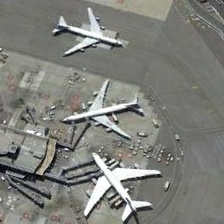
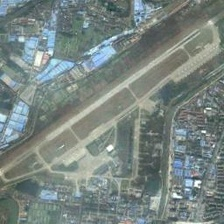
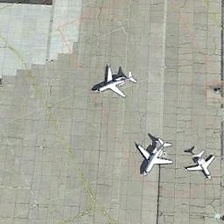
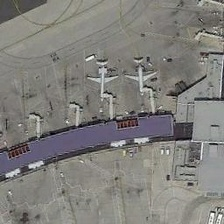

[51/100] loss=1.3074 lr=5.21e-05
[52/100] loss=2.3691 lr=5.10e-05
[53/100] loss=2.1850 lr=5.00e-05
[54/100] loss=2.2684 lr=4.90e-05
[55/100] loss=3.4221 lr=4.79e-05
[56/100] loss=3.5576 lr=4.69e-05
[57/100] loss=1.4796 lr=4.58e-05
[58/100] loss=5.5241 lr=4.48e-05
[59/100] loss=2.4178 lr=4.37e-05
[60/100] loss=1.2731 lr=4.27e-05
[61/100] loss=0.7914 lr=4.17e-05
[62/100] loss=3.3328 lr=4.06e-05
[63/100] loss=2.5412 lr=3.96e-05
[64/100] loss=1.8944 lr=3.85e-05
[65/100] loss=1.8539 lr=3.75e-05
[66/100] loss=2.3202 lr=3.65e-05
[67/100] loss=0.6133 lr=3.54e-05
[68/100] loss=2.5882 lr=3.44e-05
[69/100] loss=0.8364 lr=3.33e-05
[70/100] loss=1.2467 lr=3.23e-05
[71/100] loss=2.3112 lr=3.12e-05
[72/100] loss=1.3219 lr=3.02e-05
[73/100] loss=1.6806 lr=2.92e-05
[74/100] loss=1.1980 lr=2.81e-05
[75/100] loss=1.1349 lr=2.71e-05
[76/100] loss=3.1055 lr=2.60e-05
[77/100] loss=2.0614 lr=2.50e-05
[78/100] loss=2.7391 lr=2.40e-05
[79/100] loss=0.7583 lr=2.29e-05
[80/100] loss=0.9184 lr=2.19e-05
[81/100] l


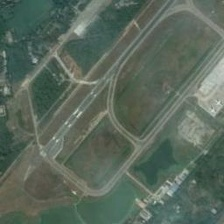
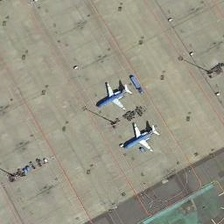
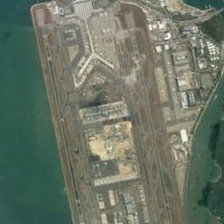
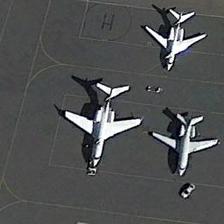

eval/bleu,█▁
eval/meteor,▁█
eval/rouge1,▁█
eval/rouge2,▁█
eval/rougeL,█▁
train/loss,█▄▅▃▃▄▂▂▂▃▃▃▂▄▄▃▂▂▂▃▂▃▃▅▂▂▁▃▂▂▂▁▁▄▂▂▂▂▂▂
train/lr,▅████▇▇▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
eval/bleu,0.0
eval/meteor,0.018
eval/rouge1,0.05547
eval/rouge2,0.01626


wandb: Agent Starting Run: esqplmgh with config:
wandb: 	init_type: zeros
wandb: 	prompt_len: 0
wandb: 	use_attn: False


[1/100] loss=5.0625 lr=2.00e-05
[2/100] loss=7.3560 lr=4.00e-05
[3/100] loss=2.8188 lr=6.00e-05
[4/100] loss=6.4858 lr=8.00e-05
[5/100] loss=6.7023 lr=1.00e-04
[6/100] loss=6.1177 lr=9.90e-05
[7/100] loss=6.2447 lr=9.79e-05
[8/100] loss=6.3406 lr=9.69e-05
[9/100] loss=7.5005 lr=9.58e-05
[10/100] loss=6.6931 lr=9.48e-05
[11/100] loss=5.4106 lr=9.38e-05
[12/100] loss=4.4629 lr=9.27e-05
[13/100] loss=6.0284 lr=9.17e-05
[14/100] loss=4.0543 lr=9.06e-05
[15/100] loss=5.2664 lr=8.96e-05
[16/100] loss=4.1448 lr=8.85e-05
[17/100] loss=4.5194 lr=8.75e-05
[18/100] loss=4.2831 lr=8.65e-05
[19/100] loss=4.2571 lr=8.54e-05
[20/100] loss=3.8748 lr=8.44e-05
[21/100] loss=6.2116 lr=8.33e-05
[22/100] loss=6.6427 lr=8.23e-05
[23/100] loss=4.7367 lr=8.13e-05
[24/100] loss=4.9266 lr=8.02e-05
[25/100] loss=5.9821 lr=7.92e-05
[26/100] loss=6.1738 lr=7.81e-05
[27/100] loss=5.0493 lr=7.71e-05
[28/100] loss=6.4047 lr=7.60e-05
[29/100] loss=4.3767 lr=7.50e-05
[30/100] loss=6.0057 lr=7.40e-05
[31/100] loss=4.576


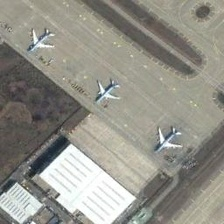
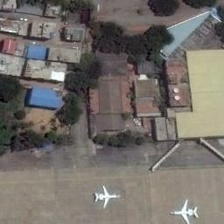
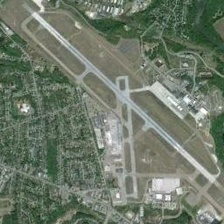
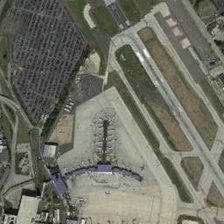

[51/100] loss=3.6275 lr=5.21e-05
[52/100] loss=6.1298 lr=5.10e-05
[53/100] loss=5.7760 lr=5.00e-05
[54/100] loss=3.6770 lr=4.90e-05
[55/100] loss=5.0347 lr=4.79e-05
[56/100] loss=4.3286 lr=4.69e-05
[57/100] loss=6.2771 lr=4.58e-05
[58/100] loss=5.0241 lr=4.48e-05
[59/100] loss=4.8254 lr=4.37e-05
[60/100] loss=4.9237 lr=4.27e-05
[61/100] loss=5.0776 lr=4.17e-05
[62/100] loss=3.0279 lr=4.06e-05
[63/100] loss=5.4547 lr=3.96e-05
[64/100] loss=5.2769 lr=3.85e-05
[65/100] loss=8.4094 lr=3.75e-05
[66/100] loss=6.1008 lr=3.65e-05
[67/100] loss=3.7433 lr=3.54e-05
[68/100] loss=3.5379 lr=3.44e-05
[69/100] loss=4.8046 lr=3.33e-05
[70/100] loss=4.7880 lr=3.23e-05
[71/100] loss=6.6012 lr=3.12e-05
[72/100] loss=4.1581 lr=3.02e-05
[73/100] loss=6.2890 lr=2.92e-05
[74/100] loss=6.6022 lr=2.81e-05
[75/100] loss=6.2058 lr=2.71e-05
[76/100] loss=3.4110 lr=2.60e-05
[77/100] loss=5.0257 lr=2.50e-05
[78/100] loss=5.7240 lr=2.40e-05
[79/100] loss=6.3605 lr=2.29e-05
[80/100] loss=4.9136 lr=2.19e-05
[81/100] l

In [ ]:
wandb.agent(sweep_id, train, count=8)   